Epoch 1/200, D Loss: 0.6948, G Loss: 0.6973
Epoch 2/200, D Loss: 0.6938, G Loss: 0.6832
Epoch 3/200, D Loss: 0.6938, G Loss: 0.6897
Epoch 4/200, D Loss: 0.6938, G Loss: 0.6770
Epoch 5/200, D Loss: 0.6936, G Loss: 0.6937
Epoch 6/200, D Loss: 0.6937, G Loss: 0.6858
Epoch 7/200, D Loss: 0.6936, G Loss: 0.6990
Epoch 8/200, D Loss: 0.6941, G Loss: 0.6814
Epoch 9/200, D Loss: 0.6932, G Loss: 0.6851
Epoch 10/200, D Loss: 0.6939, G Loss: 0.7104
Epoch 11/200, D Loss: 0.6938, G Loss: 0.6741
Epoch 12/200, D Loss: 0.6940, G Loss: 0.7041
Epoch 13/200, D Loss: 0.6938, G Loss: 0.6908
Epoch 14/200, D Loss: 0.6933, G Loss: 0.6883
Epoch 15/200, D Loss: 0.6936, G Loss: 0.6927
Epoch 16/200, D Loss: 0.6939, G Loss: 0.6917
Epoch 17/200, D Loss: 0.6936, G Loss: 0.6949
Epoch 18/200, D Loss: 0.6940, G Loss: 0.6802
Epoch 19/200, D Loss: 0.6941, G Loss: 0.6753
Epoch 20/200, D Loss: 0.6947, G Loss: 0.7101
Epoch 21/200, D Loss: 0.6948, G Loss: 0.7150
Epoch 22/200, D Loss: 0.6965, G Loss: 0.6657
Epoch 23/200, D Los

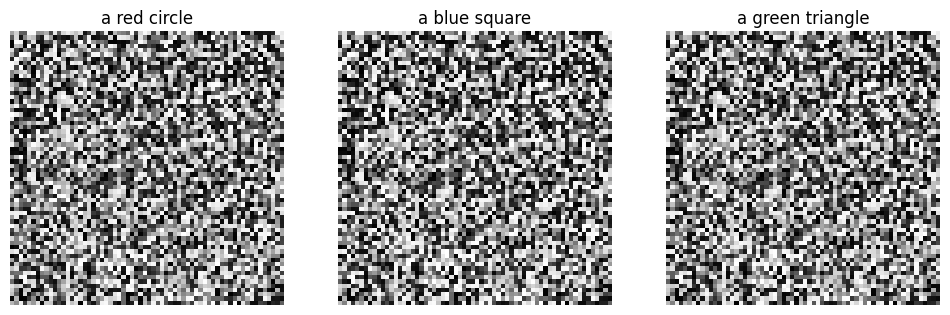

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import random

# Parameters
image_size = 64
latent_dim = 100
text_embedding_dim = 768
batch_size = 32
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample prompts
prompts = ["a red circle", "a blue square", "a green triangle"]

# Tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Dummy dataset
class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx]

dataloader = DataLoader(PromptDataset(prompts * 100), batch_size=batch_size, shuffle=True)

# Text embedding function
def get_text_embedding(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1)

# Self-Attention block
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention = self.softmax(Q @ K.transpose(-2, -1) / (x.size(-1) ** 0.5))
        return attention @ V

# Generator with cross-attention
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + text_embedding_dim, 256)
        self.attn = SelfAttention(256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, image_size * image_size)
        self.tanh = nn.Tanh()

    def forward(self, z, text_embed):
        x = torch.cat([z, text_embed], dim=1)
        x = self.fc1(x)
        x = self.attn(x.unsqueeze(1)).squeeze(1)
        x = torch.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x.view(-1, 1, image_size, image_size)

# Discriminator with text embedding
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_size * image_size + text_embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img, text_embed):
        x = torch.cat([img.view(img.size(0), -1), text_embed], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

# Training
for epoch in range(epochs):
    for batch_prompts in dataloader:
        batch_size = len(batch_prompts)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Text embedding
        text_embed = get_text_embedding(batch_prompts)

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z, text_embed)
        g_loss = loss_fn(discriminator(fake_imgs, text_embed), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        real_imgs = fake_imgs.detach()  # Here, real = generated due to lack of real dataset
        d_real_loss = loss_fn(discriminator(real_imgs, text_embed), real_labels)
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z, text_embed)
        d_fake_loss = loss_fn(discriminator(fake_imgs, text_embed), fake_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Visualization
def show_generated_images(prompt_list):
    text_embed = get_text_embedding(prompt_list)
    z = torch.randn(len(prompt_list), latent_dim).to(device)
    fake_imgs = generator(z, text_embed).detach().cpu()

    fig, axs = plt.subplots(1, len(prompt_list), figsize=(12, 4))
    for i, ax in enumerate(axs):
        ax.imshow(fake_imgs[i][0], cmap='gray')
        ax.set_title(prompt_list[i])
        ax.axis('off')
    plt.show()

show_generated_images(prompts)